# Exploring lead and cycle time with analytics and statistics
 
In this notebook I will explore answers to questions that have bothered me in my software delivery role:
* What does the team's lead time and cycle time distribution look like?
* If team reduces cycle time by 1 day:
   * How will that impact overall lead time?
   * How much more work will the team be able to deliver?
   * What will be the lead time for ad hoc requests?
* If team loads less amount of work during a Sprint:
   * How will that impact overall lead time?
   * What will be the lead time for ad hoc requests?
* Team just had an amazing/terrible Sprint. Does that mean the team is improving/regressing?
 
### Data Background
"Sprint Team" metadata was kindly provided by one of my employers. Data represents 1 feature team over 1 year period.

### Data loading, cleaning and initial visualisations 

In [70]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import stats
from scipy.stats import median_test
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import leadtimedynamics as ltdy

sprints = pd.read_csv("sprintTeam.csv")
display(sprints.head())

,Sprint,CycleTime,LeadTime
0,A,1,4
1,A,3,10
2,A,6,10
3,A,0,10
4,A,4,10


array([[<AxesSubplot:title={'center':'CycleTime'}>,
        <AxesSubplot:title={'center':'LeadTime'}>]], dtype=object)

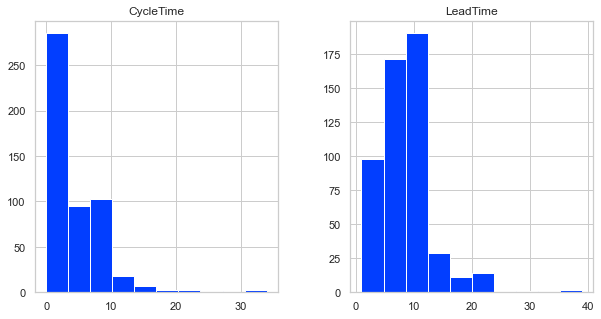

In [71]:
sprints.describe()
sprints.hist(bins=10, figsize=(10,5))

Original data length: 516, cleaned length: 505


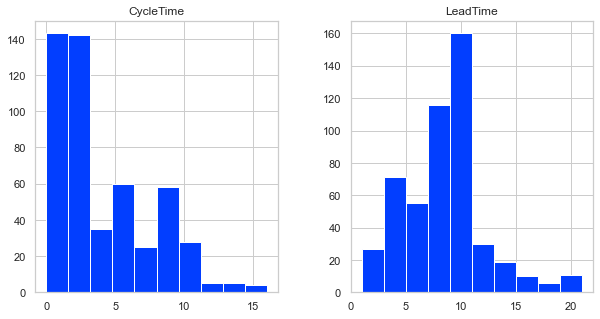

In [72]:
sprint_cycletime_z = np.abs(stats.zscore(sprints["CycleTime"]))
sprint_leadtime_z = np.abs(stats.zscore(sprints["LeadTime"]))

sprint_clean = sprints.copy(deep=True)
sprint_clean["CycleTime"] = sprint_clean["CycleTime"][np.where(sprint_cycletime_z < 3)[0]]
sprint_clean["LeadTime"] = sprint_clean["LeadTime"][np.where(sprint_leadtime_z < 3)[0]]
sprint_clean.dropna(inplace=True)

sprint_clean["CycleTime"] = sprint_clean["CycleTime"].astype(int)
sprint_clean["LeadTime"] = sprint_clean["LeadTime"].astype(int)
sprint_clean_simple = sprint_clean[["CycleTime","LeadTime"]]


sprint_clean.hist(bins=10, figsize=(10,5))
print("Original data length: {0}, cleaned length: {1}".format(len(sprints), len(sprint_clean)))

Number of work items per Sprint mean: 19, std: Count    5.832139
dtype: float64


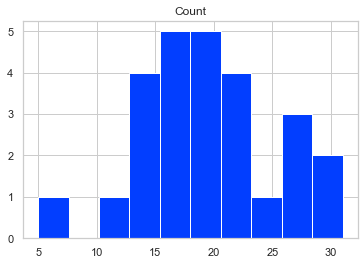

In [73]:
sprint_clean_workitem_count = sprint_clean.groupby('Sprint').agg(Count =('Sprint', 'count'))
sprint_clean_workitem_count = sprint_clean_workitem_count.reset_index()
sprint_clean_workitem_count_mean = sprint_clean_workitem_count.mean().Count.astype(int)
sprint_clean_workitem_count_std = sprint_clean_workitem_count.std()
sprint_clean_workitem_count.hist()

print("Number of work items per Sprint mean: {0}, std: {1}".format(sprint_clean_workitem_count_mean, sprint_clean_workitem_count_std))

### Q: How does team's lead time and cycle time distribution look like?
### A:

<AxesSubplot:xlabel='LeadTime'>

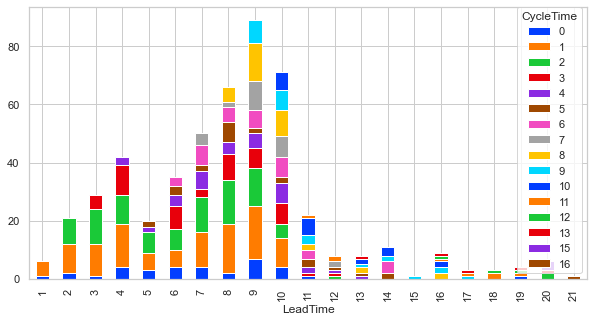

In [74]:
sprint_cycletime_p = pd.pivot_table(sprint_clean_simple, values='CycleTime', index=['CycleTime'],
                    columns=['LeadTime'], aggfunc=lambda x: len(x), fill_value=0)

sprint_cycletime_p.T.plot(kind="bar", stacked=True, figsize=(10,5))

### Q: If a team reduces cycle time by 1 day, how will that impact overall lead time?
To answer this question, I will need to simulate cycle time reduction by 1 day, two steps will need to be performed:
1. All work needs to be reduced by 1-day average
2. Space created due to reduction needs to be filled with work.

In [75]:
'''
1. Reduce 
Now we are going to reduce the work items by 1 day average.
'''
sprint_reduced = sprint_clean_simple.copy(deep=True)
ltdy.reduce(sprint_reduced.values)

'''
2. Shift left
Now that work was reduced by 1-day average we will:
* Identify how many work items were being done at the same time per day originally 
* Identify the difference between how much was being done and is being done now
But before that is done, let's see the space that was created:
'''
original_leadtime_sum, original_leadtime_sum_labels = ltdy.leadtime_trail(ltdy.unroll(sprint_clean_simple.values))
reduced_leadtime_sum, reduced_leadtime_sum_labels = ltdy.leadtime_trail(ltdy.unroll(sprint_reduced.values))
space = ltdy.array_normalise_size(original_leadtime_sum, reduced_leadtime_sum)

'''
3. Shift work into the available space that was created by the reduction
'''
original_leadtime_sum, original_leadtime_sum_labels = ltdy.leadtime_trail(ltdy.unroll(sprint_clean_simple.values))

shifted = None
shifted_total = 0
workitems_shifted = copy.deepcopy(sprint_reduced.values)
iterations = 0
while shifted == None or shifted > 0:
    empty_blocks = []
    shifted_leadtime_sum, shifted_leadtime_sum_labels = ltdy.leadtime_trail(ltdy.unroll(workitems_shifted))
    shifted_leadtime_sum = ltdy.array_normalise_size(original_leadtime_sum, shifted_leadtime_sum)
    empty_space = original_leadtime_sum - shifted_leadtime_sum
    ltdy.create_blocks(empty_space, 0, len(empty_space), empty_blocks)
    workitems_to_shift_by_1_day = np.array(empty_blocks)+[0, 1]
    workitem_hash = ltdy.array_to_hash(workitems_shifted)
    shifted = ltdy.shift_left(workitem_hash, workitems_to_shift_by_1_day)
    shifted_total += shifted
    workitems_shifted = ltdy.hash_to_array(workitem_hash)
    iterations += 1


### A:
Below you can see the lead time profile change when cycle time is reduced by 1-day average across all work.

<AxesSubplot:xlabel='LeadTime'>

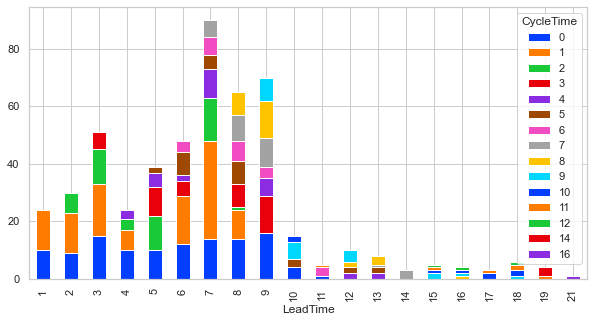

In [76]:
sprint_shifted_cycletime_p = pd.pivot_table(pd.DataFrame(workitems_shifted, columns=['CycleTime', 'LeadTime']), values='CycleTime', index=['CycleTime'], columns=['LeadTime'], aggfunc=lambda x: len(x), fill_value=0)
sprint_shifted_cycletime_p.T.plot(kind="bar", stacked=True, figsize=(10,5))


In [77]:
print("> Amount of work delivered originally: {0}, after shift left: {1}".format(len(sprint_clean_simple), len(workitems_shifted)))


> Amount of work delivered originally: 505, after shift left: 505


It is important to note that amount of work before and after that is being done is still the same. However, if we take a look at the "shift efficiency review" we will see that there are plenty of space (blue). Let's see how much work we can "pack" into this space.

### Q: If team reduces cycle time by 1 day, how much more work will team be able to deliver?
### A:

In [78]:

shifted_leadtime_sum, shifted_leadtime_sum_labels = ltdy.leadtime_trail(ltdy.unroll(workitems_shifted))
shifted_leadtime_sum = ltdy.array_normalise_size(original_leadtime_sum, shifted_leadtime_sum)
empty_space = original_leadtime_sum - shifted_leadtime_sum
empty_blocks = []
ltdy.create_blocks(empty_space, 0, len(empty_space), empty_blocks)
shift_increase = len(empty_blocks) / len(workitems_shifted) 
print("> After shift left it is possible to deliver additional: {0} work items, per Sprint this will yield ~{1:.2%} increase.".format(len(empty_blocks), shift_increase))


> After shift left it is possible to deliver additional: 162 work items, per Sprint this will yield ~32.08% increase.


This additional work will change the profile of the lead time, here is how it will look like now:


> Amount of work delivered originally: 505, after shift left and packing: 667


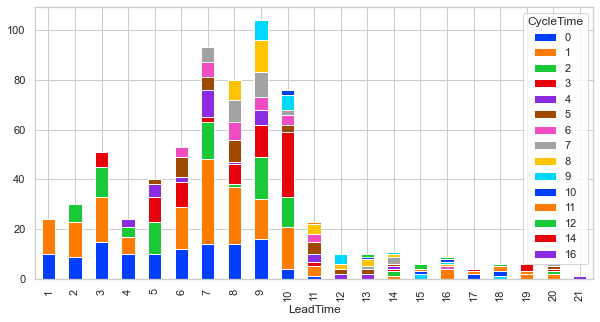

In [79]:

workitems_shifted_packed = copy.deepcopy(workitems_shifted)
workitem_hash = ltdy.array_to_hash(workitems_shifted_packed)
ltdy.shift_in(workitem_hash, empty_blocks)
workitems_shifted_packed = ltdy.hash_to_array(workitem_hash)

sprint_packed = pd.DataFrame(workitems_shifted_packed, columns=['CycleTime', 'LeadTime'])
sprint_shifted_packed_cycletime_p = pd.pivot_table(sprint_packed, values='CycleTime', index=['CycleTime'], columns=['LeadTime'], aggfunc=lambda x: len(x), fill_value=0)
sprint_shifted_packed_cycletime_p.T.plot(kind="bar", stacked=True, figsize=(10,5))

print("> Amount of work delivered originally: {0}, after shift left and packing: {1}".format(len(sprint_clean_simple), len(workitems_shifted_packed)))

Please note that this is an approximation, packing this much work takes you almost (you are delivering more work after all) back to where you started from i.e. a lot of work being delivered late in the Sprint. Please also and work items that can fill the available space are biassed towards smaller size see below graph:

<AxesSubplot:>

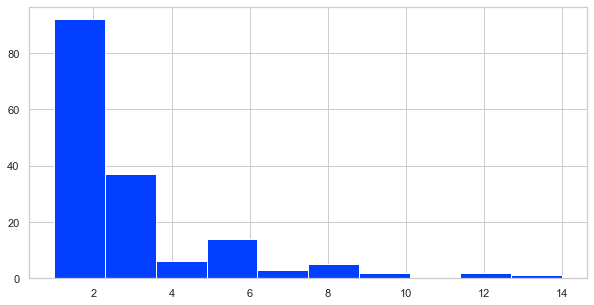

In [80]:
workitems_to_pack = pd.DataFrame(empty_blocks, columns=['CycleTime', 'LeadTime'])
workitems_to_pack["CycleTime"].hist(bins=10, figsize=(10,5))

### Q: If team reduces cycle time by 1 day, what will be the lead time for ad hoc requests?
### A:

Unfortunately ad hoc lead time on average will always be  ~10 days. This is because as more space gets created for more work, more work gets packed in. Until empty space is created for ad hoc work in the Sprint this will not change.
### Q: If a team loads less amount of work during a Sprint, how will that impact overall lead time?
### A:
 
Sprint lead time profile will follow the same pattern as cycle time "reduction and shift". Meaning that work will be front-loaded leaving space at the end of the Sprint.
 
### Q: If a team loads less amount of work during a Sprint, what will be the lead time for ad hoc requests?
### A:
As per above answer, Sprint work will be front-loaded meaning, this is because all team members will start on the work that is available and switch to new work when they finish their existing work. This means that ad hoc work in a Sprint will most likely be done at the end of the Sprint.
 
### Q: Team just had an amazing/terrible Sprint. Does that mean the team is improving/regressing?
### A:

p-value: 0.8713020178714097   p-value < 0.05: False


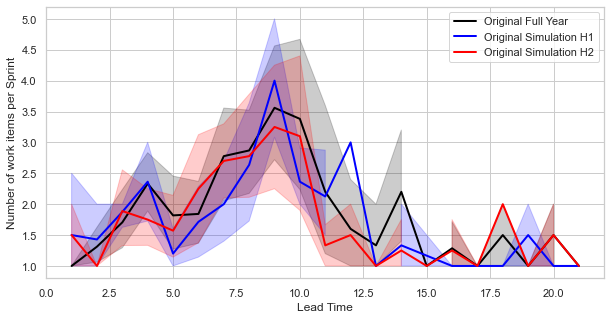

In [102]:
def sprint_data_to_aggregate(sprint_data):
    sprint_data_agg = []
    df_sprint_data = pd.DataFrame(sprint_data, columns=['Sprint','CycleTime', 'LeadTime'])
    df_sprint_data['CycleTime'] = df_sprint_data['CycleTime'].astype(int)
    df_sprint_data['LeadTime'] = df_sprint_data['LeadTime'].astype(int)
    for row in df_sprint_data.groupby(["Sprint", "LeadTime"]).agg({ 'LeadTime': 'count'}).itertuples():
        sprint_data_agg.append([row.Index[0], row.Index[1], row.LeadTime])
    df_sprint_data_agg = pd.DataFrame(sprint_data_agg, columns=['Sprint','LeadTime', 'Count'])
    return df_sprint_data_agg


sprint_clean_simulation_h1 = np.empty([0, 3])
for i in range(12):
    sprint_workitems = ltdy.construct_sprint(chr(65+i), sprint_clean_workitem_count_mean, sprint_clean_workitem_count_std,sprint_clean_simple.values)
    sprint_clean_simulation_h1 = np.vstack((sprint_clean_simulation_h1, sprint_workitems))

sprint_clean_simulation_h2 = np.empty([0, 3])
for i in range(12):
    sprint_workitems = ltdy.construct_sprint(chr(65+i), sprint_clean_workitem_count_mean, sprint_clean_workitem_count_std,sprint_clean_simple.values)
    sprint_clean_simulation_h2 = np.vstack((sprint_clean_simulation_h2, sprint_workitems))


df_sprint_simulation_agg_h1 = sprint_data_to_aggregate(sprint_clean_simulation_h1)
df_sprint_simulation_agg_h2 = sprint_data_to_aggregate(sprint_clean_simulation_h2)
df_sprint_clean_agg = sprint_data_to_aggregate(sprint_clean)


stat, p, med, tbl = median_test(sprint_clean_simulation_h1[:,2].astype(int),sprint_clean_simple.values[:, 1])

f, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style="whitegrid", palette="bright")
sns.lineplot(data=df_sprint_clean_agg, color="black", linewidth=2, x="LeadTime", y="Count", label="Original Full Year")
sns.lineplot(data=df_sprint_simulation_agg_h1, color="blue", linewidth=2, x="LeadTime", y="Count", label="Original Simulation H1")
sns.lineplot(data=df_sprint_simulation_agg_h2, color="red", linewidth=2, x="LeadTime", y="Count", label="Original Simulation H2")
ax.xaxis.grid(True)
ax.legend()
ax.set(ylabel="Number of work items per Sprint", xlabel="Lead Time")
print("p-value:",p, " ", "p-value < 0.05:", p < 0.05)


If you take a look at the above graph you will see how different versions of original data could have played out under the same distribution! At this point it is important to take a moment to understand that there are **many possibilities** of what could have happened. It might "feel" better or worse, however it might be just noise and there is no regression or improvement at all.
 
We should agree at this point that "Original Full Year" and "Original Simulation H1/H2" are not different from each other. To confirm this statistically it is possible to use the median test. If you look just above the graph you will see p-value and p-value < 0.05 being false indicating that lead time data is from the same distribution.
 
If this is all the same, then what does an improvement look like? For this we will use our shifted and shifted+packed data from above.


p-value: 0.005516837832819801   p-value < 0.05: True


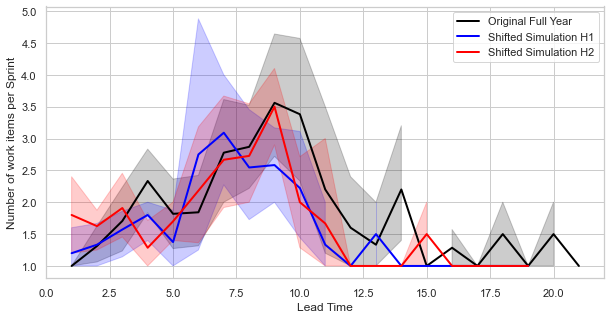

In [103]:
sprint_shifted_simulation_h1 = np.empty([0, 3])
for i in range(12):
    sprint_workitems = ltdy.construct_sprint(chr(65+i), sprint_clean_workitem_count_mean, sprint_clean_workitem_count_std,sprint_reduced.values)
    sprint_shifted_simulation_h1 = np.vstack((sprint_shifted_simulation_h1, sprint_workitems))

sprint_shifted_simulation_h2 = np.empty([0, 3])
for i in range(12):
    sprint_workitems = ltdy.construct_sprint(chr(65+i), sprint_clean_workitem_count_mean, sprint_clean_workitem_count_std,sprint_reduced.values)
    sprint_shifted_simulation_h2 = np.vstack((sprint_shifted_simulation_h2, sprint_workitems))

df_sprint_shifted_agg_h1 = sprint_data_to_aggregate(sprint_shifted_simulation_h1)
df_sprint_shifted_agg_h2 = sprint_data_to_aggregate(sprint_shifted_simulation_h2)

stat, p, med, tbl = median_test(sprint_shifted_simulation_h1[:,2].astype(int),sprint_clean_simple.values[:, 1])

f, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style="whitegrid", palette="bright")
sns.lineplot(data=df_sprint_clean_agg, color="black", linewidth=2, x="LeadTime", y="Count", label="Original Full Year")
sns.lineplot(data=df_sprint_shifted_agg_h1, color="blue", linewidth=2, x="LeadTime", y="Count", label="Shifted Simulation H1")
sns.lineplot(data=df_sprint_shifted_agg_h2, color="red", linewidth=2, x="LeadTime", y="Count", label="Shifted Simulation H2")
ax.xaxis.grid(True)
ax.legend()
ax.set(ylabel="Number of work items per Sprint", xlabel="Lead Time")
print("p-value:",p, " ", "p-value < 0.05:", p < 0.05)

If you look at the above you will see significant improvement, especially around the tail of the graph.
 
Take note of the p-value and p-value < 0.05 being true indicating that data is NOT from the same distribution.
 
Now we have previously discussed that if so much work is shifted to the left most likely more work will be loaded, so it could be argued that above is not a realistic test. Shifted+packed graph below provides a much more realistic perspective.

p-value: 4.4753070735096896e-07   p-value < 0.05: True


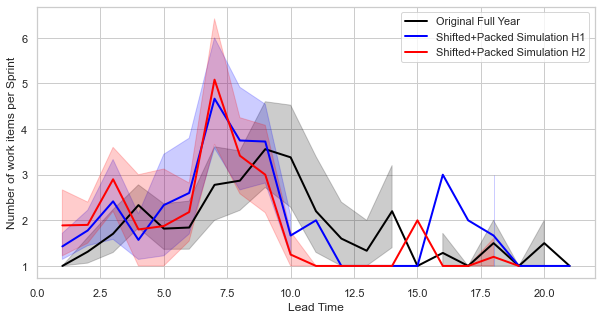

In [104]:
sprint_shifted_packed_simulation_h1 = np.empty([0, 3])
for i in range(12):
    sprint_workitems = ltdy.construct_sprint(chr(65+i), sprint_clean_workitem_count_mean*(1+shift_increase), sprint_clean_workitem_count_std,workitems_shifted)
    sprint_shifted_packed_simulation_h1 = np.vstack((sprint_shifted_packed_simulation_h1, sprint_workitems))

sprint_shifted_packed_simulation_h2 = np.empty([0, 3])
for i in range(12):
    sprint_workitems = ltdy.construct_sprint(chr(65+i), sprint_clean_workitem_count_mean*(1+shift_increase), sprint_clean_workitem_count_std,workitems_shifted)
    sprint_shifted_packed_simulation_h2 = np.vstack((sprint_shifted_packed_simulation_h2, sprint_workitems))

df_sprint_shifted_packed_agg_h1 = sprint_data_to_aggregate(sprint_shifted_packed_simulation_h1)
df_sprint_shifted_packed_agg_h2 = sprint_data_to_aggregate(sprint_shifted_packed_simulation_h2)

stat, p, med, tbl = median_test(sprint_shifted_packed_simulation_h1[:,2].astype(int),sprint_clean_simple.values[:, 1])

f, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style="whitegrid", palette="bright")
sns.lineplot(data=df_sprint_clean_agg, color="black", linewidth=2, x="LeadTime", y="Count", label="Original Full Year")
sns.lineplot(data=df_sprint_shifted_packed_agg_h1, color="blue", linewidth=2, x="LeadTime", y="Count", label="Shifted+Packed Simulation H1")
sns.lineplot(data=df_sprint_shifted_packed_agg_h2, color="red", linewidth=2, x="LeadTime", y="Count", label="Shifted+Packed Simulation H2")
ax.xaxis.grid(True)
ax.legend()
ax.set(ylabel="Number of work items per Sprint", xlabel="Lead Time")
print("p-value:",p, " ", "p-value < 0.05:", p < 0.05)

### Q: What can we learn from all of this? (Conclusion, TL;DR)
### A: 
* Team can improve cycle time by: 
    * 1) Delivering value more incrementally by making sure that work items are as small as possible (however not too small as you still want to deliver real value).
    * 2) Engaging the whole team on the work item as much as possible to minimise total work in progress and cycle time.
    * 3) Reducing wait, disruption and task time to reduce cycle time.  
* Improved productivity charts will very likely look like the original with more work being done on average.
* Teams need be mindful of randomness when reviewing their performance, there needs to be a significant improvement or regression for it cause excitement or concern.
* The only way to reduce work from being "backended" is by delivering smaller work items, the smaller the work items more evenly the work will be distributed through the Sprint. 
* Little's Law can't be used over time series Sprint data, this is because Sprint data does not follow normal distribution.